# File reading and data processing

In [1]:
### Setup the library ###
import pyrogue  as pr
import pyrogue.protocols
import pyrogue.utilities.fileio
import rogue

import os, sys
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )
import setupLibPaths

import ePix320kM as fpgaBoard

import numpy as np
from matplotlib import pyplot as plt

# Initialization code and helper function

In [2]:
readerReceiver = fpgaBoard.DataDebug(name = "readerReceiver")
fread = rogue.utilities.fileio.StreamReader()
readUnbatcher = rogue.protocols.batcher.SplitterV1() 
readerReceiver << readUnbatcher << fread
readerReceiver.enableDataDebug(True)
readerReceiver.enableDebugPrint(True)
        
def readFromFile(filename) :

    readerReceiver.cleanData()
    fread.open(filename)
    fread.closeWait()

# READ file and descramble

In [104]:
# Has good performance

ssdPath = "/u1/ePixHRM320k/acquisition"
# filename = f"{ssdPath}/dark_1us.dat"
# filename = f"{ssdPath}/Cd_m21V.dat"
filename = f"{ssdPath}/testLR.dat"


readFromFile(filename)

In [105]:
np.shape(readerReceiver.getData())

(192, 384, 1000)

# Save data into numpy array (optional)


In [106]:
# np.save('/u1/ePixHRM320k/numpy/dark_1us.numpy', readerReceiver.getData())

# Remove average = 'dark' from dataset, works only in low occupancy!

In [107]:
# Remove pixels at the edges
# data = np.copy(readerReceiver.getData()[:,:,0:100]).astype(float)
data = np.copy(readerReceiver.getData()[:,:,0:10000]).astype(float)
print(np.shape(data))

# Remove dark (only works if low-occupancy!!)
data -= np.median(data, axis=2, keepdims=True)

(192, 384, 1000)


# Apply row/col common-mode correction on frame-by-frame  (optional)

In [108]:
# Common mode correction on both arrays
data -= np.median(data, axis=(0,1), keepdims=True)
data -= np.median(data, axis=1, keepdims=True) # rows (cols)
# data -= np.median(data, axis=0, keepdims=True) # cols (rows)

Median Noise [ADUs]: 38.52995062850361


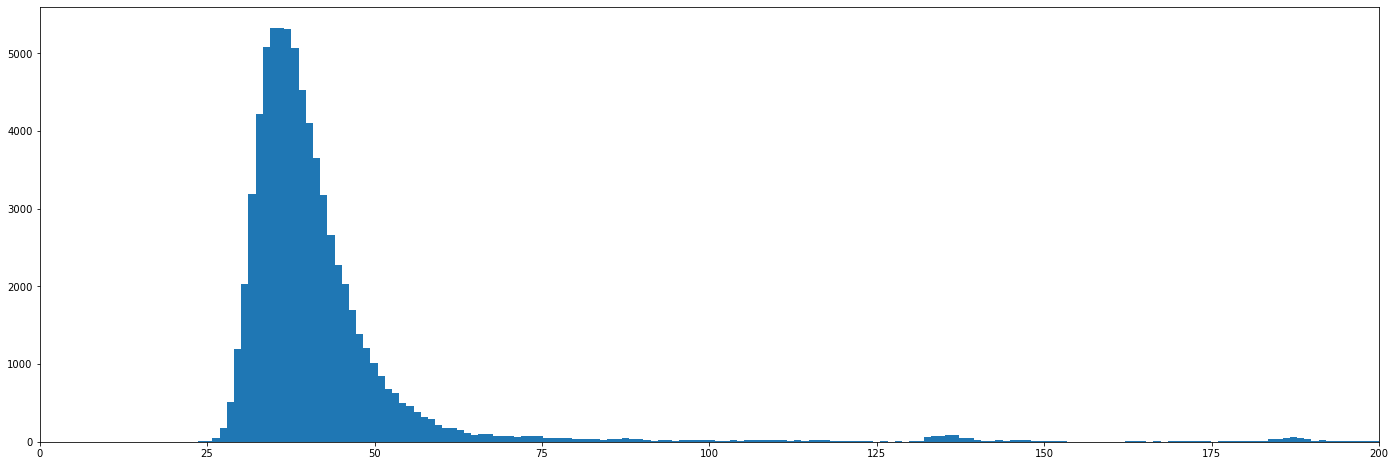

In [111]:
# Calculate noise
noise = np.std(data, axis=2, keepdims=True)
fig, ax = plt.subplots(figsize=(24, 8))

ax.hist(noise.flatten(),bins=1000)
ax.set_xlim([0,200])

noise = np.median(noise)

print('Median Noise [ADUs]:',noise)

# Function to filter noisy pixels with noise > 2xSTD (optional)
#  works only in low occupancy!

Noise_median:  38.52995062850361


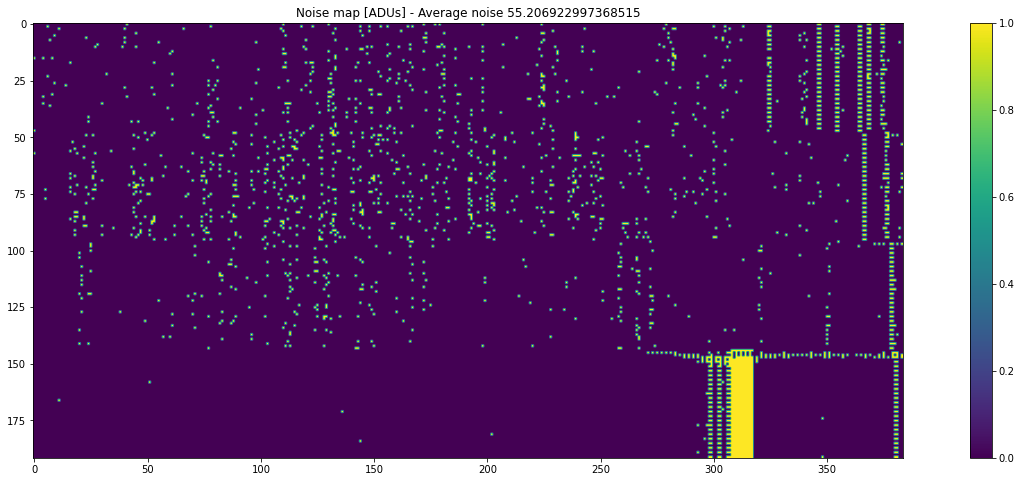

In [112]:
# filter bad pixels
def filter_bad_pixels(data):
    
    num_noisy_pixels = 0
       
    # Get median of signal
    data_median = np.median(data)
    
    # Get noise of pixels
    pixels_noise = np.std(data, axis=2)
    noise_median = np.median(pixels_noise)
    print('Noise_median: ', noise_median)
   
    noisy_pixels = pixels_noise > (2*noise_median)
    noisy_pixels = noisy_pixels[:,:, np.newaxis]
    noisy_pixels = np.repeat(noisy_pixels, np.shape(data)[2], axis=2)
    
    data[noisy_pixels] = data_median

    fig, ax = plt.subplots(figsize=(24, 8))
    plt.imshow(pixels_noise)
    plt.imshow(noisy_pixels[:,:,0])
    plt.title('Noise map [ADUs] - Average noise {}'.format(noise_pix))
    plt.colorbar()
    
    return data, noise_median

data, noise_pix = filter_bad_pixels(data)

# Plot noise map

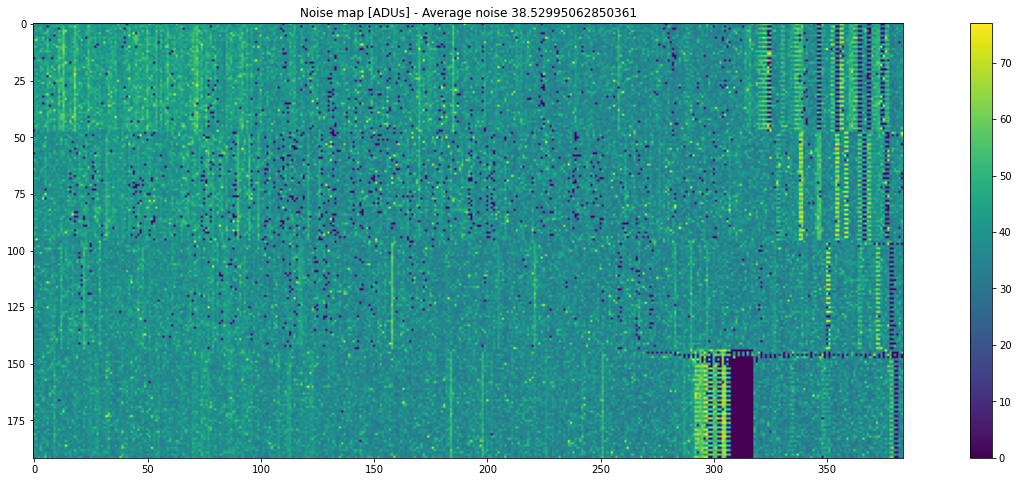

In [113]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.imshow(np.std(data, axis=2))
plt.title('Noise map [ADUs] - Average noise {}'.format(noise_pix))
plt.colorbar()

# Plot few images for quick inspection 

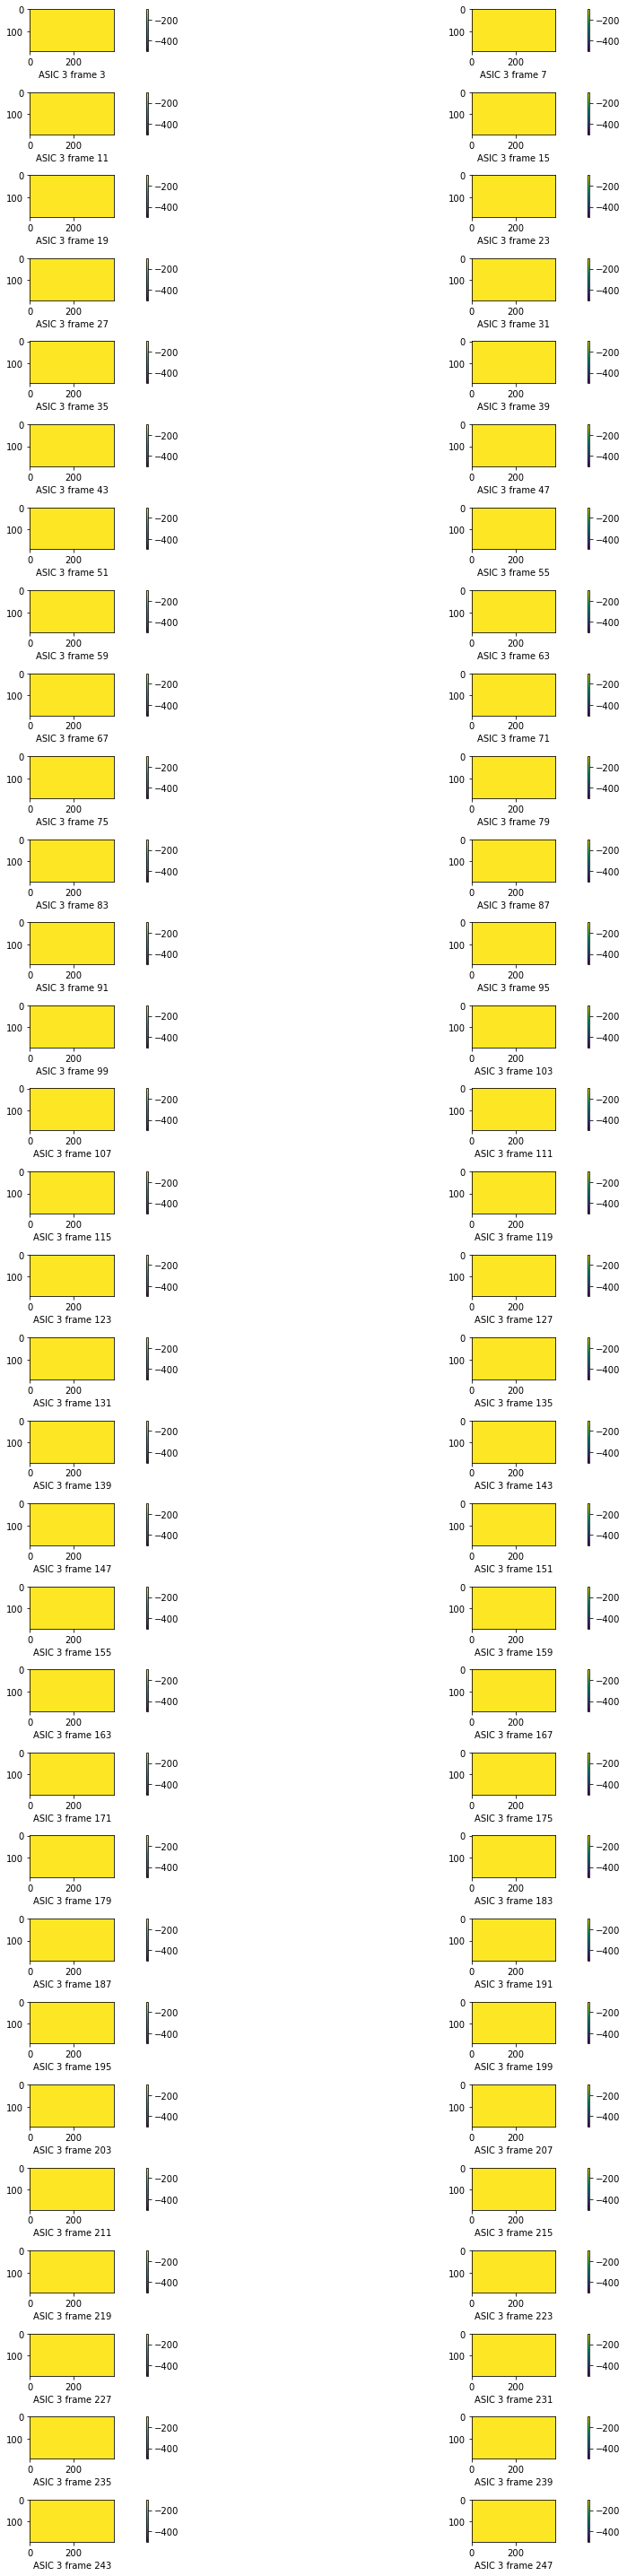

In [114]:
rows = int(np.shape(data)[2] / (4*8))
cols = 2
plt.subplots(rows,cols,figsize=(17,40))

for imageIndex in range(rows*cols):
    plt.subplot(rows,cols,imageIndex+1)
     
    plt.imshow(data[:,:,imageIndex * 4 + 3], vmin=-500, vmax=-100)
    plt.xlabel("ASIC 3 frame {}".format(imageIndex * 4 + 3))
    plt.colorbar()

plt.tight_layout()

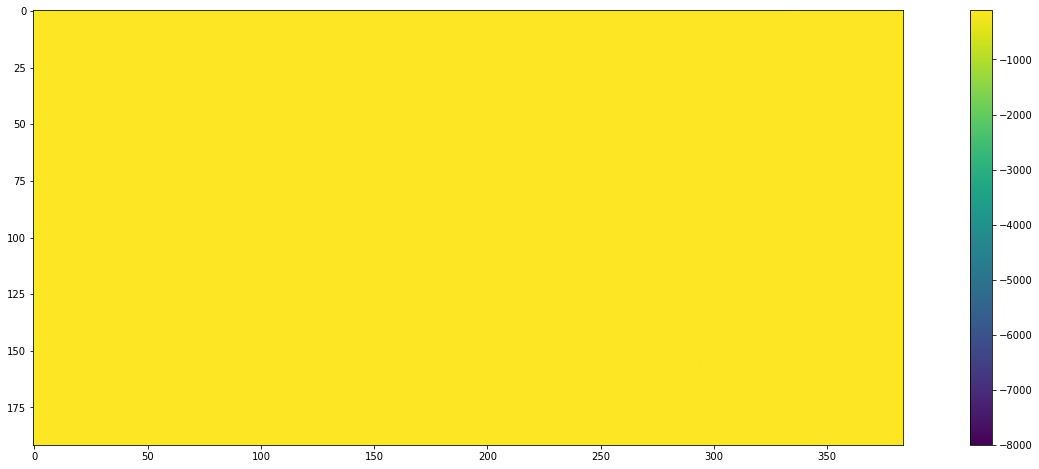

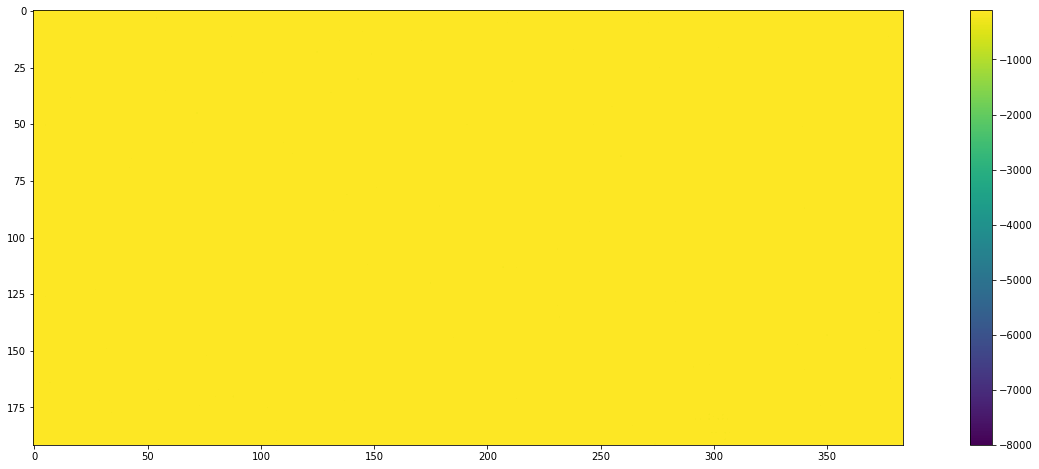

In [115]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.imshow(data[:,:,100], vmin=-8000, vmax=-100)
plt.colorbar()

fig, ax = plt.subplots(figsize=(24, 8))
plt.imshow(data[:,:,101], vmin=-8000, vmax=-100)
plt.colorbar()

In [116]:
# Flatten 2D array
data_flat = data[:,:,:].flatten()
data_hist, data_bins = np.histogram(data_flat, bins=np.arange(int(min(data_flat)), int(max(data_flat)), 1))

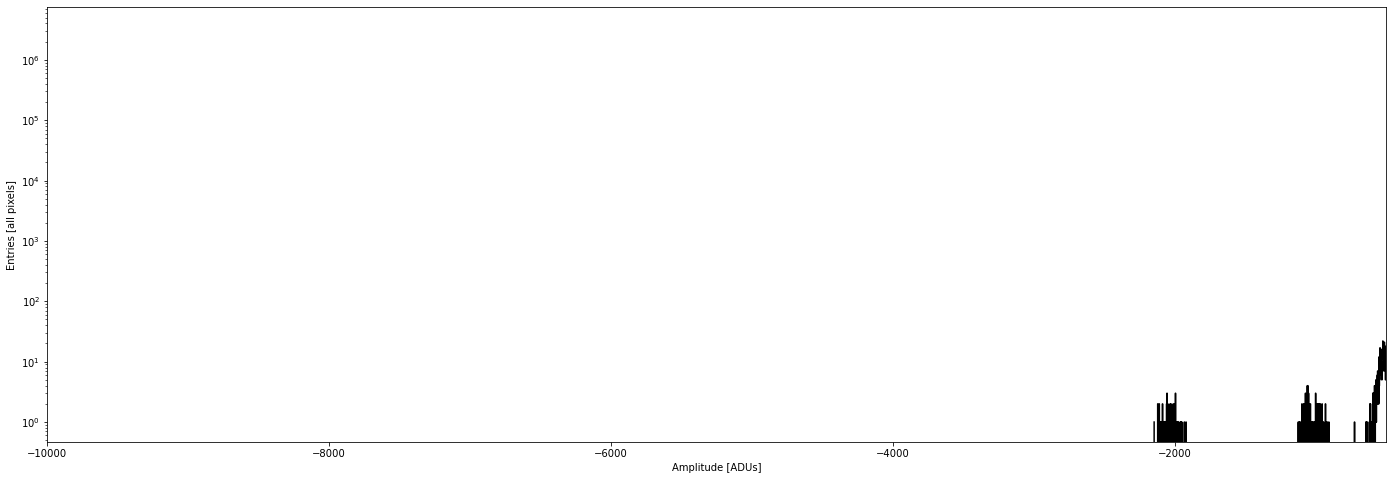

In [117]:
#Plot histogram
fig, ax = plt.subplots(figsize=(24, 8))
ax.step(data_bins[:-1]+0.5, data_hist,'k')

ax.set_xlabel('Amplitude [ADUs]')
ax.set_xlim([-10000,-500])
ax.set_ylabel('Entries [all pixels]')
ax.set_yscale('log')

# Show plot
plt.show()